In [5]:
import pandas as pd
import numpy as np
import altair as alt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder, StandardScaler
import src.util as util
import yaml
import copy
from tqdm import tqdm
import os
from datetime import datetime
import openpyxl
from transformers import BertTokenizer, BertModel
import torch
from sklearn.metrics.pairwise import cosine_similarity

In [6]:
config_data=util.config_load()

In [7]:
df_simil_in=util.pickle_load(config_data['raw_dataset_path_data_simil'])
df_ICD_embeddings=util.pickle_load(config_data['raw_dataset_path_ICD_embeddings_combined'])
df_DRG_embeddings=util.pickle_load(config_data['raw_dataset_path_DRG_embeddings'])
df_PRC_embeddings=util.pickle_load(config_data['raw_dataset_path_PROC_embeddings'])

In [8]:
df_simil_in.columns

Index(['Provider', 'Is_admit', 'ClmAdmitDiagnosisCode', 'DiagnosisGroupCode',
       'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
       'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
       'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9',
       'ClmDiagnosisCode_10', 'ClmProcedureCode_1', 'ClmProcedureCode_2',
       'ClmProcedureCode_3'],
      dtype='object')

In [9]:
df_simil_diag_count=df_simil_in.copy()

In [10]:
def pad_code(code):
    if pd.isna(code):
        return code  # Keep NaN as is
    return str(code).zfill(4)  # Pad with zeros to make it 4 characters



In [11]:
for i in [ 'ClmAdmitDiagnosisCode', 'DiagnosisGroupCode',
       'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
       'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
       'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9',
       'ClmDiagnosisCode_10', 'ClmProcedureCode_1', 'ClmProcedureCode_2',
       'ClmProcedureCode_3']:
    df_simil_in[i].astype(str)
    df_simil_in[i].replace(r'\.0$', '', regex=True,inplace=True)
    df_simil_in[i].replace(r'nan', np.nan, regex=True,inplace=True)
    df_simil_in[i]=df_simil_in[i].apply(pad_code)

/var/folders/nd/f34czdrj02175j4j_k03vfyw0000gp/T/ipykernel_1141/1800943709.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_simil_in[i].replace(r'\.0$', '', regex=True,inplace=True)
/var/folders/nd/f34czdrj02175j4j_k03vfyw0000gp/T/ipykernel_1141/1800943709.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting v

In [12]:
def convert_ICD_to_embeddings(df,Lookup_df,Coding_ind):
    dict_icd=Lookup_df.set_index('CODE')['embeddings'].to_dict() 
    def ICD_check_embeddings(code):
        if isinstance(code,str) and code.startswith('V'):
            key=code[:3]
            return dict_icd.get(key,[0.0]*768)
        else:
            return dict_icd.get(code,[0.0]*768)
    if Coding_ind.startswith("ICD"):    
        for i in ['Value']:
            df[i+'_embeddings'] = df[i].map(ICD_check_embeddings)
    elif Coding_ind.startswith("DRG"):
        for i in ['DiagnosisGroupCode']:
            df[i+'_embeddings'] = df[i].map(ICD_check_embeddings)
    else:
        if  Coding_ind.startswith("PRC"):
            for i in ['ClmProcedureCode_1', 'ClmProcedureCode_2',
            'ClmProcedureCode_3']:
                df[i+'_embeddings'] = df[i].map(ICD_check_embeddings)


In [13]:
convert_ICD_to_embeddings(df_simil_in,df_ICD_embeddings,'ICD')

KeyError: 'Value'

In [10]:
convert_ICD_to_embeddings(df_simil_in,df_DRG_embeddings,'DRG')

In [11]:
convert_ICD_to_embeddings(df_simil_in,df_PRC_embeddings,'PRC')

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x106ccb2c0>>
Traceback (most recent call last):
  File "/Users/Geethika/Documents/GitHub/Medicare Claims/.venv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


In [12]:
df_simil_in.isna().sum()

Provider                      0
Is_admit                      0
ClmAdmitDiagnosisCode    412312
DiagnosisGroupCode       517737
ClmDiagnosisCode_1        10453
ClmDiagnosisCode_2       195606
ClmDiagnosisCode_3       315156
ClmDiagnosisCode_4       393675
ClmDiagnosisCode_5       446287
ClmDiagnosisCode_6       473819
ClmDiagnosisCode_7       492034
ClmDiagnosisCode_8       504767
ClmDiagnosisCode_9       516396
ClmDiagnosisCode_10      553201
ClmProcedureCode_1       534901
ClmProcedureCode_2       552721
ClmProcedureCode_3       557242
dtype: int64

In [53]:
df_simil_in.columns

Index(['Provider', 'Is_admit', 'ClmAdmitDiagnosisCode', 'DiagnosisGroupCode',
       'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
       'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
       'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9',
       'ClmDiagnosisCode_10', 'ClmProcedureCode_1', 'ClmProcedureCode_2',
       'ClmProcedureCode_3', 'ClmAdmitDiagnosisCode_embeddings',
       'ClmDiagnosisCode_1_embeddings', 'ClmDiagnosisCode_2_embeddings',
       'ClmDiagnosisCode_3_embeddings', 'ClmDiagnosisCode_4_embeddings',
       'ClmDiagnosisCode_5_embeddings', 'ClmDiagnosisCode_6_embeddings',
       'ClmDiagnosisCode_7_embeddings', 'ClmDiagnosisCode_8_embeddings',
       'ClmDiagnosisCode_9_embeddings', 'ClmDiagnosisCode_10_embeddings',
       'DiagnosisGroupCode_embeddings', 'ClmProcedureCode_1_embeddings',
       'ClmProcedureCode_2_embeddings', 'ClmProcedureCode_3_embeddings'],
      dtype='object')

In [18]:
df_simil_in_embeddings=df_simil_in[['ClmDiagnosisCode_1_embeddings', 'ClmDiagnosisCode_2_embeddings',
       'ClmDiagnosisCode_3_embeddings', 'ClmDiagnosisCode_4_embeddings',
       'ClmDiagnosisCode_5_embeddings', 'ClmDiagnosisCode_6_embeddings',
       'ClmDiagnosisCode_7_embeddings', 'ClmDiagnosisCode_8_embeddings',
       'ClmDiagnosisCode_9_embeddings', 'ClmDiagnosisCode_10_embeddings']]

In [21]:
df_simil_in_embeddings

,ClmDiagnosisCode_1_embeddings,ClmDiagnosisCode_2_embeddings,ClmDiagnosisCode_3_embeddings,ClmDiagnosisCode_4_embeddings,ClmDiagnosisCode_5_embeddings,ClmDiagnosisCode_6_embeddings,ClmDiagnosisCode_7_embeddings,ClmDiagnosisCode_8_embeddings,ClmDiagnosisCode_9_embeddings,ClmDiagnosisCode_10_embeddings
0,"[0.010667440481483936, -0.3797340989112854, -0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,"[0.41847023367881775, -0.2877976894378662, -0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[0.17872802913188934, -0.06236257031559944, -0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"[0.17826981842517853, -0.19420212507247925, -0...","[0.29401230812072754, -0.34514421224594116, -0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[0.5887888073921204, -0.07212638854980469, -0....","[0.020234394818544388, -0.21725228428840637, -...","[0.08858256787061691, -0.32604023814201355, -0...","[0.08467984944581985, -0.4215394854545593, -0....","[0.13901440799236298, -0.5541523694992065, -0....","[-0.026387019082903862, -0.7416917085647583, -...","[0.33459001779556274, -0.42721250653266907, -0...","[0.31543871760368347, -0.4194205701351166, -0....","[0.425546258687973, -0.5643200278282166, -0.17...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...,...,...
558206,"[0.09414944797754288, 0.00439474917948246, -0....","[0.2041909098625183, -0.42897817492485046, -0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
558207,"[0.20434194803237915, -0.25642743706703186, -0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

In [9]:
columns=[ 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
       'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
       'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9',
       'ClmDiagnosisCode_10']
non_zero_rows = []

for col in columns:
    non_zero_values = df_simil_in[col]
    for value in non_zero_values:
        if value != 0 and pd.notna(value):
            non_zero_rows.append({'Column': col, 'Value': value})

# Create a new DataFrame from the non-zero values
non_zero_df = pd.DataFrame(non_zero_rows)

# Display the new DataFrame
unique_non_zero_df = non_zero_df.drop_duplicates()

In [10]:
unique_non_zero_df

,Column,Value
0,ClmDiagnosisCode_1,79678
1,ClmDiagnosisCode_1,71656
2,ClmDiagnosisCode_1,64881
3,ClmDiagnosisCode_1,36401
4,ClmDiagnosisCode_1,2948
...,...,...
1680698,ClmDiagnosisCode_10,20501
1680700,ClmDiagnosisCode_10,59654
1680702,ClmDiagnosisCode_10,4470
1680711,ClmDiagnosisCode_10,20380


In [11]:
convert_ICD_to_embeddings(unique_non_zero_df,df_ICD_embeddings,'ICD')

/var/folders/nd/f34czdrj02175j4j_k03vfyw0000gp/T/ipykernel_38524/4279810846.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i+'_embeddings'] = df[i].map(ICD_check_embeddings)


In [102]:
unique_non_zero_df

,Column,Value,Value_embeddings
0,ClmDiagnosisCode_1,79678,"[0.010667440481483936, -0.3797340989112854, -0..."
1,ClmDiagnosisCode_1,71656,"[0.41847023367881775, -0.2877976894378662, -0...."
2,ClmDiagnosisCode_1,64881,"[0.17872802913188934, -0.06236257031559944, -0..."
3,ClmDiagnosisCode_1,36401,"[0.17826981842517853, -0.19420212507247925, -0..."
4,ClmDiagnosisCode_1,2948,"[0.5887888073921204, -0.07212638854980469, -0...."
...,...,...,...
1680698,ClmDiagnosisCode_10,20501,"[-0.04702998697757721, -0.24099653959274292, -..."
1680700,ClmDiagnosisCode_10,59654,"[-0.0665954127907753, -0.043210119009017944, -..."
1680702,ClmDiagnosisCode_10,4470,"[-0.28070810437202454, -0.4402160346508026, -0..."
1680711,ClmDiagnosisCode_10,20380,"[0.23849999904632568, -0.28297585248947144, -0..."


In [13]:
unique_non_zero_df.isna().sum()

Column              0
Value               0
Value_embeddings    0
dtype: int64

In [14]:
embeddings_array = unique_non_zero_df['Value_embeddings']

In [45]:
embeddings_array

0          [0.010667440481483936, -0.3797340989112854, -0...
1          [0.41847023367881775, -0.2877976894378662, -0....
2          [0.17872802913188934, -0.06236257031559944, -0...
3          [0.17826981842517853, -0.19420212507247925, -0...
4          [0.5887888073921204, -0.07212638854980469, -0....
                                 ...                        
1680698    [-0.04702998697757721, -0.24099653959274292, -...
1680700    [-0.0665954127907753, -0.043210119009017944, -...
1680702    [-0.28070810437202454, -0.4402160346508026, -0...
1680711    [0.23849999904632568, -0.28297585248947144, -0...
1680714    [0.37640902400016785, -0.6570141911506653, -0....
Name: Value_embeddings, Length: 42783, dtype: object

In [15]:

# Define a function to calculate cosine similarity in chunks
def calculate_similarity_in_chunks(df, chunk_size):
    similarity_dfs = []
    
    for start in range(0, len(df), chunk_size):
        end = min(start + chunk_size, len(df))
        chunk = df[start:end]

        # Convert the list of embeddings to a 2D array
        embeddings_array = pd.Series(chunk['Value_embeddings']).apply(pd.Series).values
        
        # Calculate the cosine similarity
        similarity_matrix = cosine_similarity(embeddings_array)
        
        # Convert to DataFrame for better readability
        chunk_similarity_df = pd.DataFrame(
            similarity_matrix, 
            index=chunk['Value'], 
            columns=chunk['Value']
        )
        
        # Append the chunk similarity DataFrame to the list
        similarity_dfs.append(chunk_similarity_df)

    # Combine all chunk DataFrames into one
    return pd.concat(similarity_dfs)

# Calculate the cosine similarity in chunks
chunk_size = 100  # Set your desired chunk size
df_similarity = calculate_similarity_in_chunks(unique_non_zero_df, chunk_size)

# Display the similarity DataFrame
print("Cosine Similarity Matrix:")
print(df_similarity)

Cosine Similarity Matrix:
Value     79678     71656     64881     36401      2948     31400     42490  \
Value                                                                         
79678  1.000000  0.889981  0.897131  0.897980  0.890620  0.895838  0.890685   
71656  0.889981  1.000000  0.899280  0.890023  0.897151  0.879297  0.902413   
64881  0.897131  0.899280  1.000000  0.888400  0.914363  0.884394  0.887588   
36401  0.897980  0.890023  0.888400  1.000000  0.905234  0.894868  0.926345   
2948   0.890620  0.897151  0.914363  0.905234  1.000000  0.888567  0.893218   
...         ...       ...       ...       ...       ...       ...       ...   
20501       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
59654       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
4470        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
20380       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
5733        NaN       NaN 

In [25]:
df_similarity.fillna(0,inplace=True)

In [45]:
df_similarity.columns

Index(['79678', '71656', '64881', '36401', '2948', '31400', '42490', '11590',
       '72089', '4271',
       ...
       'E9888', 'E8710', '3203', '94225', 'E8259', '90241', '0828', 'E8262',
       'E9192', '86131'],
      dtype='object', name='Value', length=10981)

In [35]:
data=df_group_data_diag_simil.drop(columns='Provider').dot(df_similarity.values)

In [42]:
data

,0,1,2,3,4,5,6,7,8,9,...,10971,10972,10973,10974,10975,10976,10977,10978,10979,10980
0,4.448246,44.736784,8.860778,4.593130,50.838706,86.979082,46.012642,30.555489,20.146631,115.559432,...,4.174175,0.000000,10.529650,0.916312,0.907648,0.82918,7.153037,1.760201,0.000000,0.933080
1,3.570520,28.451379,4.427285,3.663936,22.438268,35.676416,32.486534,8.840333,5.454927,59.669544,...,0.893548,0.866638,0.886225,0.000000,0.000000,0.00000,2.626134,0.000000,0.870483,0.000000
2,0.000000,38.404240,5.362335,0.000000,23.311049,77.079434,35.188310,9.575178,12.904735,84.622695,...,3.393852,0.904733,6.148156,0.000000,0.000000,0.00000,2.670272,0.927139,0.000000,0.896457
3,0.000000,4.473106,0.900019,0.000000,0.860820,5.238786,3.567008,2.654306,0.000000,8.090033,...,0.000000,0.000000,0.886225,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
4,0.000000,4.520625,0.000000,0.000000,0.000000,15.065316,5.403818,2.654615,0.000000,12.342326,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5405,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5406,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5407,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5408,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
data.columns=df_similarity.columns

In [48]:
data['Provider']=df_group_data_diag_simil['Provider']

In [50]:
data.fillna(0,inplace=True)

In [52]:
data

Value,79678,71656,64881,36401,2948,31400,42490,11590,72089,4271,...,E8710,3203,94225,E8259,90241,0828,E8262,E9192,86131,Provider
0,4.448246,44.736784,8.860778,4.593130,50.838706,86.979082,46.012642,30.555489,20.146631,115.559432,...,0.000000,10.529650,0.916312,0.907648,0.82918,7.153037,1.760201,0.000000,0.933080,PRV57172
1,3.570520,28.451379,4.427285,3.663936,22.438268,35.676416,32.486534,8.840333,5.454927,59.669544,...,0.866638,0.886225,0.000000,0.000000,0.00000,2.626134,0.000000,0.870483,0.000000,PRV55158
2,0.000000,38.404240,5.362335,0.000000,23.311049,77.079434,35.188310,9.575178,12.904735,84.622695,...,0.904733,6.148156,0.000000,0.000000,0.00000,2.670272,0.927139,0.000000,0.896457,PRV54966
3,0.000000,4.473106,0.900019,0.000000,0.860820,5.238786,3.567008,2.654306,0.000000,8.090033,...,0.000000,0.886225,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,PRV54890
4,0.000000,4.520625,0.000000,0.000000,0.000000,15.065316,5.403818,2.654615,0.000000,12.342326,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,PRV52145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5405,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,PRV54294
5406,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,PRV51053
5407,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,PRV55405
5408,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,PRV57061


In [54]:
df_simil_in.dtypes

Provider                            object
Is_admit                             int64
ClmAdmitDiagnosisCode               object
DiagnosisGroupCode                  object
ClmDiagnosisCode_1                  object
ClmDiagnosisCode_2                  object
ClmDiagnosisCode_3                  object
ClmDiagnosisCode_4                  object
ClmDiagnosisCode_5                  object
ClmDiagnosisCode_6                  object
ClmDiagnosisCode_7                  object
ClmDiagnosisCode_8                  object
ClmDiagnosisCode_9                  object
ClmDiagnosisCode_10                 object
ClmProcedureCode_1                  object
ClmProcedureCode_2                  object
ClmProcedureCode_3                  object
ClmAdmitDiagnosisCode_embeddings    object
ClmDiagnosisCode_1_embeddings       object
ClmDiagnosisCode_2_embeddings       object
ClmDiagnosisCode_3_embeddings       object
ClmDiagnosisCode_4_embeddings       object
ClmDiagnosisCode_5_embeddings       object
ClmDiagnosi

In [243]:
df_simil_in['Procedure_code_mean'] = df_simil_in[['ClmProcedureCode_1_embeddings', 
                                                         'ClmProcedureCode_2_embeddings', 
                                                         'ClmProcedureCode_3_embeddings']].sum(axis=1)

In [244]:
df_simil_in['Diagnosis_Combined_mean'] = df_simil_in[['ClmDiagnosisCode_1_embeddings', 
                                                         'ClmDiagnosisCode_2_embeddings', 
                                                         'ClmDiagnosisCode_3_embeddings', 
                                                         'ClmDiagnosisCode_4_embeddings', 
                                                         'ClmDiagnosisCode_5_embeddings', 
                                                         'ClmDiagnosisCode_6_embeddings', 
                                                         'ClmDiagnosisCode_7_embeddings', 
                                                         'ClmDiagnosisCode_8_embeddings', 
                                                         'ClmDiagnosisCode_9_embeddings', 
                                                         'ClmDiagnosisCode_10_embeddings']].sum(axis=1)

In [57]:
def similarity_scoring(df,col1,col2):

    
    def cosine_simi(x):
        vec1 = np.array(x[col1])
        vec2 = np.array(x[col2])
        max_length = max(len(vec1), len(vec2))
        vector_a_padded = np.pad(vec1, (0, max_length - len(vec1)), 'constant')
        vector_b_padded = np.pad(vec2, (0, max_length - len(vec2)), 'constant')

        # Reshape the vectors to 2D
        vec1 = vector_a_padded.reshape(1, -1)  # Shape (1, n_features)
        vec2 = vector_b_padded.reshape(1, -1)  # Shape (1, n_features)

        # Calculate cosine similarity
        similarity_cosine = cosine_similarity(vec1, vec2)
        return similarity_cosine

    df[col1+'_'+col2+'_similarity']=df[[col1,col2]].apply(lambda x : cosine_simi(x),axis=1)



In [245]:
similarity_scoring(df_simil_in,'Diagnosis_Combined_mean','Procedure_code_mean')
similarity_scoring(df_simil_in,'Diagnosis_Combined_mean','DiagnosisGroupCode_embeddings')
similarity_scoring(df_simil_in,'Diagnosis_Combined_mean','ClmAdmitDiagnosisCode_embeddings')
similarity_scoring(df_simil_in,'DiagnosisGroupCode_embeddings','ClmAdmitDiagnosisCode_embeddings')



In [249]:

def cov_simil_to_float(df,column):
    df[column+'_float']=df[column].apply(lambda x:float(x[0]))

for i in df_simil_in.columns[df_simil_in.columns.str.contains('similarity')]:
    cov_simil_to_float(df_simil_in,i)


/var/folders/nd/f34czdrj02175j4j_k03vfyw0000gp/T/ipykernel_20916/4251744133.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  df[column+'_float']=df[column].apply(lambda x:float(x[0]))
/var/folders/nd/f34czdrj02175j4j_k03vfyw0000gp/T/ipykernel_20916/4251744133.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  df[column+'_float']=df[column].apply(lambda x:float(x[0]))
/var/folders/nd/f34czdrj02175j4j_k03vfyw0000gp/T/ipykernel_20916/4251744133.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this opera

In [ ]:
df_simil_in_cp=df_simil_in.copy()

In [272]:
df_simil_in.columns

Index(['Provider', 'Is_admit', 'ClmAdmitDiagnosisCode', 'DiagnosisGroupCode',
       'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
       'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
       'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9',
       'ClmDiagnosisCode_10', 'ClmProcedureCode_1', 'ClmProcedureCode_2',
       'ClmProcedureCode_3',
       'Diagnosis_Combined_mean_Procedure_code_mean_similarity_float',
       'Diagnosis_Combined_mean_DiagnosisGroupCode_embeddings_similarity_float',
       'Diagnosis_Combined_mean_ClmAdmitDiagnosisCode_embeddings_similarity_float',
       'DiagnosisGroupCode_embeddings_ClmAdmitDiagnosisCode_embeddings_similarity_float',
       'ClmDiagnosisCode_1_embeddings_ClmDiagnosisCode_2_embeddings_similarity_float',
       'ClmDiagnosisCode_2_embeddings_ClmDiagnosisCode_3_embeddings_similarity_float',
       'ClmDiagnosisCode_3_embeddings_ClmDiagnosisCode_4_embeddings_similarity_float',
       'ClmDi

In [61]:
df_simil_in.drop(columns=['ClmAdmitDiagnosisCode', 'DiagnosisGroupCode',
       'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
       'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
       'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9',
       'ClmDiagnosisCode_10', 'ClmProcedureCode_1', 'ClmProcedureCode_2',
       'ClmProcedureCode_3', 'ClmAdmitDiagnosisCode_embeddings',
       'ClmDiagnosisCode_1_embeddings', 'ClmDiagnosisCode_2_embeddings',
       'ClmDiagnosisCode_3_embeddings', 'ClmDiagnosisCode_4_embeddings',
       'ClmDiagnosisCode_5_embeddings', 'ClmDiagnosisCode_6_embeddings',
       'ClmDiagnosisCode_7_embeddings', 'ClmDiagnosisCode_8_embeddings',
       'ClmDiagnosisCode_9_embeddings', 'ClmDiagnosisCode_10_embeddings',
       'DiagnosisGroupCode_embeddings', 'ClmProcedureCode_1_embeddings',
       'ClmProcedureCode_2_embeddings', 'ClmProcedureCode_3_embeddings',
       'Procedure_code_mean', 'Diagnosis_Combined_mean',
       'Diagnosis_Combined_mean_Procedure_code_mean_similarity',
       'Diagnosis_Combined_mean_DiagnosisGroupCode_embeddings_similarity',
       'Diagnosis_Combined_mean_ClmAdmitDiagnosisCode_embeddings_similarity',
       'DiagnosisGroupCode_embeddings_ClmAdmitDiagnosisCode_embeddings_similarity'],inplace=True,axis=1)


In [271]:
df_simil_in.drop(columns=['ClmAdmitDiagnosisCode_embeddings',
       'ClmDiagnosisCode_1_embeddings', 'ClmDiagnosisCode_2_embeddings',
       'ClmDiagnosisCode_3_embeddings', 'ClmDiagnosisCode_4_embeddings',
       'ClmDiagnosisCode_5_embeddings', 'ClmDiagnosisCode_6_embeddings',
       'ClmDiagnosisCode_7_embeddings', 'ClmDiagnosisCode_8_embeddings',
       'ClmDiagnosisCode_9_embeddings', 'ClmDiagnosisCode_10_embeddings',
       'DiagnosisGroupCode_embeddings', 'ClmProcedureCode_1_embeddings',
       'ClmProcedureCode_2_embeddings', 'ClmProcedureCode_3_embeddings',
       'Procedure_code_mean', 'Diagnosis_Combined_mean',
       'Diagnosis_Combined_mean_Procedure_code_mean_similarity',
       'Diagnosis_Combined_mean_DiagnosisGroupCode_embeddings_similarity',
       'Diagnosis_Combined_mean_ClmAdmitDiagnosisCode_embeddings_similarity',
       'DiagnosisGroupCode_embeddings_ClmAdmitDiagnosisCode_embeddings_similarity',
       'ClmDiagnosisCode_1_embeddings_ClmDiagnosisCode_2_embeddings_similarity',
       'ClmDiagnosisCode_2_embeddings_ClmDiagnosisCode_3_embeddings_similarity',
       'ClmDiagnosisCode_3_embeddings_ClmDiagnosisCode_4_embeddings_similarity',
       'ClmDiagnosisCode_4_embeddings_ClmDiagnosisCode_5_embeddings_similarity',
       'ClmDiagnosisCode_5_embeddings_ClmDiagnosisCode_6_embeddings_similarity',
       'ClmDiagnosisCode_6_embeddings_ClmDiagnosisCode_7_embeddings_similarity',
       'ClmDiagnosisCode_7_embeddings_ClmDiagnosisCode_8_embeddings_similarity',
       'ClmDiagnosisCode_8_embeddings_ClmDiagnosisCode_9_embeddings_similarity'],inplace=True,axis=1)


KeyError: "['ClmAdmitDiagnosisCode_embeddings', 'ClmDiagnosisCode_1_embeddings', 'ClmDiagnosisCode_2_embeddings', 'ClmDiagnosisCode_3_embeddings', 'ClmDiagnosisCode_4_embeddings', 'ClmDiagnosisCode_5_embeddings', 'ClmDiagnosisCode_6_embeddings', 'ClmDiagnosisCode_7_embeddings', 'ClmDiagnosisCode_8_embeddings', 'ClmDiagnosisCode_9_embeddings', 'ClmDiagnosisCode_10_embeddings', 'DiagnosisGroupCode_embeddings', 'ClmProcedureCode_1_embeddings', 'ClmProcedureCode_2_embeddings', 'ClmProcedureCode_3_embeddings', 'Procedure_code_mean', 'Diagnosis_Combined_mean', 'Diagnosis_Combined_mean_Procedure_code_mean_similarity', 'Diagnosis_Combined_mean_DiagnosisGroupCode_embeddings_similarity', 'Diagnosis_Combined_mean_ClmAdmitDiagnosisCode_embeddings_similarity', 'DiagnosisGroupCode_embeddings_ClmAdmitDiagnosisCode_embeddings_similarity', 'ClmDiagnosisCode_1_embeddings_ClmDiagnosisCode_2_embeddings_similarity', 'ClmDiagnosisCode_2_embeddings_ClmDiagnosisCode_3_embeddings_similarity', 'ClmDiagnosisCode_3_embeddings_ClmDiagnosisCode_4_embeddings_similarity', 'ClmDiagnosisCode_4_embeddings_ClmDiagnosisCode_5_embeddings_similarity', 'ClmDiagnosisCode_5_embeddings_ClmDiagnosisCode_6_embeddings_similarity', 'ClmDiagnosisCode_6_embeddings_ClmDiagnosisCode_7_embeddings_similarity', 'ClmDiagnosisCode_7_embeddings_ClmDiagnosisCode_8_embeddings_similarity', 'ClmDiagnosisCode_8_embeddings_ClmDiagnosisCode_9_embeddings_similarity'] not found in axis"

In [270]:
df_simil_in.fillna(0,inplace=True)

In [273]:
def simil_agg_pivot_combine(df,col):
    df_agg_diag_comb=pd.DataFrame()
    df_agg_diag_comb=df.groupby(['Provider','Is_admit'])[col].mean().reset_index()
    pivoted_df=df_agg_diag_comb.pivot_table(index='Provider',columns='Is_admit',values=i,
                                aggfunc='mean').reset_index()
    pivoted_df.columns.name = None  # Remove the name of the columns index
    pivoted_df = pivoted_df.rename(columns={0: col+'_Not Admitted', 1: col+'_Admitted'})
    return pivoted_df

In [276]:
df_simil_in.columns[df_simil_in.columns.str.contains('similarity_float')]

Index(['Diagnosis_Combined_mean_Procedure_code_mean_similarity_float',
       'Diagnosis_Combined_mean_DiagnosisGroupCode_embeddings_similarity_float',
       'Diagnosis_Combined_mean_ClmAdmitDiagnosisCode_embeddings_similarity_float',
       'DiagnosisGroupCode_embeddings_ClmAdmitDiagnosisCode_embeddings_similarity_float',
       'ClmDiagnosisCode_1_embeddings_ClmDiagnosisCode_2_embeddings_similarity_float',
       'ClmDiagnosisCode_2_embeddings_ClmDiagnosisCode_3_embeddings_similarity_float',
       'ClmDiagnosisCode_3_embeddings_ClmDiagnosisCode_4_embeddings_similarity_float',
       'ClmDiagnosisCode_4_embeddings_ClmDiagnosisCode_5_embeddings_similarity_float',
       'ClmDiagnosisCode_5_embeddings_ClmDiagnosisCode_6_embeddings_similarity_float',
       'ClmDiagnosisCode_6_embeddings_ClmDiagnosisCode_7_embeddings_similarity_float',
       'ClmDiagnosisCode_7_embeddings_ClmDiagnosisCode_8_embeddings_similarity_float',
       'ClmDiagnosisCode_8_embeddings_ClmDiagnosisCode_9_embeddin

In [368]:
df_simil_in

,Provider,Is_admit,ClmAdmitDiagnosisCode,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,...,Diagnosis_Combined_mean_ClmAdmitDiagnosisCode_embeddings_similarity_float,DiagnosisGroupCode_embeddings_ClmAdmitDiagnosisCode_embeddings_similarity_float,ClmDiagnosisCode_1_embeddings_ClmDiagnosisCode_2_embeddings_similarity_float,ClmDiagnosisCode_2_embeddings_ClmDiagnosisCode_3_embeddings_similarity_float,ClmDiagnosisCode_3_embeddings_ClmDiagnosisCode_4_embeddings_similarity_float,ClmDiagnosisCode_4_embeddings_ClmDiagnosisCode_5_embeddings_similarity_float,ClmDiagnosisCode_5_embeddings_ClmDiagnosisCode_6_embeddings_similarity_float,ClmDiagnosisCode_6_embeddings_ClmDiagnosisCode_7_embeddings_similarity_float,ClmDiagnosisCode_7_embeddings_ClmDiagnosisCode_8_embeddings_similarity_float,ClmDiagnosisCode_8_embeddings_ClmDiagnosisCode_9_embeddings_similarity_float
0,PRV57172,0,0,0,79678,0,0,0,0,0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,PRV57172,0,0,0,71656,0,0,0,0,0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,PRV55158,0,64880,0,64881,0,0,0,0,0,...,0.957305,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,PRV54966,0,36401,0,36401,V4569,0,0,0,0,...,0.711949,0.0,0.902907,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,PRV54890,0,78009,0,2948,4019,2989,78054,2875,78830,...,0.308186,0.0,0.897208,0.952786,0.901493,0.948612,0.944085,0.893478,0.875444,0.903405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558206,PRV55826,0,V7283,0,V7282,V420,0,0,0,0,...,0.709753,0.0,0.862252,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
558207,PRV54670,0,0,0,V103,0,0,0,0,0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
558208,PRV57336,0,0,0,185,0,0,0,0,0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
558209,PRV51690,0,78720,0,71690,0,0,0,0,0,...,0.946620,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [277]:
df_simil_agg_combined=pd.DataFrame(df_simil_in['Provider'].unique(),columns=['Provider'])
for i in df_simil_in.columns[df_simil_in.columns.str.contains('similarity_float')]:
    piv_df=simil_agg_pivot_combine(df_simil_in,i)
    df_simil_agg_combined=df_simil_agg_combined.merge(piv_df,on='Provider')

In [278]:
df_simil_agg_combined

,Provider,Diagnosis_Combined_mean_Procedure_code_mean_similarity_float_Not Admitted,Diagnosis_Combined_mean_Procedure_code_mean_similarity_float_Admitted,Diagnosis_Combined_mean_DiagnosisGroupCode_embeddings_similarity_float_Not Admitted,Diagnosis_Combined_mean_DiagnosisGroupCode_embeddings_similarity_float_Admitted,Diagnosis_Combined_mean_ClmAdmitDiagnosisCode_embeddings_similarity_float_Not Admitted,Diagnosis_Combined_mean_ClmAdmitDiagnosisCode_embeddings_similarity_float_Admitted,DiagnosisGroupCode_embeddings_ClmAdmitDiagnosisCode_embeddings_similarity_float_Not Admitted,DiagnosisGroupCode_embeddings_ClmAdmitDiagnosisCode_embeddings_similarity_float_Admitted,ClmDiagnosisCode_1_embeddings_ClmDiagnosisCode_2_embeddings_similarity_float_Not Admitted,...,ClmDiagnosisCode_4_embeddings_ClmDiagnosisCode_5_embeddings_similarity_float_Not Admitted,ClmDiagnosisCode_4_embeddings_ClmDiagnosisCode_5_embeddings_similarity_float_Admitted,ClmDiagnosisCode_5_embeddings_ClmDiagnosisCode_6_embeddings_similarity_float_Not Admitted,ClmDiagnosisCode_5_embeddings_ClmDiagnosisCode_6_embeddings_similarity_float_Admitted,ClmDiagnosisCode_6_embeddings_ClmDiagnosisCode_7_embeddings_similarity_float_Not Admitted,ClmDiagnosisCode_6_embeddings_ClmDiagnosisCode_7_embeddings_similarity_float_Admitted,ClmDiagnosisCode_7_embeddings_ClmDiagnosisCode_8_embeddings_similarity_float_Not Admitted,ClmDiagnosisCode_7_embeddings_ClmDiagnosisCode_8_embeddings_similarity_float_Admitted,ClmDiagnosisCode_8_embeddings_ClmDiagnosisCode_9_embeddings_similarity_float_Not Admitted,ClmDiagnosisCode_8_embeddings_ClmDiagnosisCode_9_embeddings_similarity_float_Admitted
0,PRV57172,0.000000,0.201718,0.0,0.325841,0.137136,0.343706,0.0,0.879751,0.568692,...,0.134460,0.806577,0.094027,0.760091,0.060389,0.693289,0.044047,0.644046,0.033351,0.582871
1,PRV55158,0.000000,0.189464,0.0,0.300008,0.139332,0.314060,0.0,0.880306,0.563914,...,0.129560,0.877427,0.084777,0.878674,0.051924,0.826390,0.035935,0.787220,0.029173,0.769657
2,PRV54966,0.000172,NaN,0.0,NaN,0.141303,NaN,0.0,NaN,0.547872,...,0.123058,NaN,0.079984,NaN,0.051180,NaN,0.039084,NaN,0.029217,NaN
3,PRV54890,0.000000,0.173346,0.0,0.303265,0.144436,0.317259,0.0,0.885077,0.610970,...,0.172763,0.893758,0.134924,0.893234,0.085666,0.871830,0.060144,0.657347,0.049223,0.671336
4,PRV52145,0.000000,NaN,0.0,NaN,0.122383,NaN,0.0,NaN,0.594563,...,0.119727,NaN,0.083185,NaN,0.051027,NaN,0.024833,NaN,0.014439,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5405,PRV54294,0.000000,NaN,0.0,NaN,0.000000,NaN,0.0,NaN,0.853264,...,0.893813,NaN,0.918408,NaN,0.909886,NaN,0.882759,NaN,0.000000,NaN
5406,PRV51053,NaN,0.284195,NaN,0.295862,NaN,0.298200,NaN,0.901135,NaN,...,NaN,0.917193,NaN,0.919335,NaN,0.839986,NaN,0.870648,NaN,0.824793
5407,PRV55405,0.000000,NaN,0.0,NaN,0.000000,NaN,0.0,NaN,0.614734,...,0.088409,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN
5408,PRV57061,0.000000,NaN,0.0,NaN,0.690904,NaN,0.0,NaN,0.928131,...,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN


In [279]:
util.pickle_dump(df_simil_agg_combined, config_data["raw_dataset_path_agg_simil_scores"]) 


In [280]:
df_simil_agg_combined

,Provider,Diagnosis_Combined_mean_Procedure_code_mean_similarity_float_Not Admitted,Diagnosis_Combined_mean_Procedure_code_mean_similarity_float_Admitted,Diagnosis_Combined_mean_DiagnosisGroupCode_embeddings_similarity_float_Not Admitted,Diagnosis_Combined_mean_DiagnosisGroupCode_embeddings_similarity_float_Admitted,Diagnosis_Combined_mean_ClmAdmitDiagnosisCode_embeddings_similarity_float_Not Admitted,Diagnosis_Combined_mean_ClmAdmitDiagnosisCode_embeddings_similarity_float_Admitted,DiagnosisGroupCode_embeddings_ClmAdmitDiagnosisCode_embeddings_similarity_float_Not Admitted,DiagnosisGroupCode_embeddings_ClmAdmitDiagnosisCode_embeddings_similarity_float_Admitted,ClmDiagnosisCode_1_embeddings_ClmDiagnosisCode_2_embeddings_similarity_float_Not Admitted,...,ClmDiagnosisCode_4_embeddings_ClmDiagnosisCode_5_embeddings_similarity_float_Not Admitted,ClmDiagnosisCode_4_embeddings_ClmDiagnosisCode_5_embeddings_similarity_float_Admitted,ClmDiagnosisCode_5_embeddings_ClmDiagnosisCode_6_embeddings_similarity_float_Not Admitted,ClmDiagnosisCode_5_embeddings_ClmDiagnosisCode_6_embeddings_similarity_float_Admitted,ClmDiagnosisCode_6_embeddings_ClmDiagnosisCode_7_embeddings_similarity_float_Not Admitted,ClmDiagnosisCode_6_embeddings_ClmDiagnosisCode_7_embeddings_similarity_float_Admitted,ClmDiagnosisCode_7_embeddings_ClmDiagnosisCode_8_embeddings_similarity_float_Not Admitted,ClmDiagnosisCode_7_embeddings_ClmDiagnosisCode_8_embeddings_similarity_float_Admitted,ClmDiagnosisCode_8_embeddings_ClmDiagnosisCode_9_embeddings_similarity_float_Not Admitted,ClmDiagnosisCode_8_embeddings_ClmDiagnosisCode_9_embeddings_similarity_float_Admitted
0,PRV57172,0.000000,0.201718,0.0,0.325841,0.137136,0.343706,0.0,0.879751,0.568692,...,0.134460,0.806577,0.094027,0.760091,0.060389,0.693289,0.044047,0.644046,0.033351,0.582871
1,PRV55158,0.000000,0.189464,0.0,0.300008,0.139332,0.314060,0.0,0.880306,0.563914,...,0.129560,0.877427,0.084777,0.878674,0.051924,0.826390,0.035935,0.787220,0.029173,0.769657
2,PRV54966,0.000172,NaN,0.0,NaN,0.141303,NaN,0.0,NaN,0.547872,...,0.123058,NaN,0.079984,NaN,0.051180,NaN,0.039084,NaN,0.029217,NaN
3,PRV54890,0.000000,0.173346,0.0,0.303265,0.144436,0.317259,0.0,0.885077,0.610970,...,0.172763,0.893758,0.134924,0.893234,0.085666,0.871830,0.060144,0.657347,0.049223,0.671336
4,PRV52145,0.000000,NaN,0.0,NaN,0.122383,NaN,0.0,NaN,0.594563,...,0.119727,NaN,0.083185,NaN,0.051027,NaN,0.024833,NaN,0.014439,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5405,PRV54294,0.000000,NaN,0.0,NaN,0.000000,NaN,0.0,NaN,0.853264,...,0.893813,NaN,0.918408,NaN,0.909886,NaN,0.882759,NaN,0.000000,NaN
5406,PRV51053,NaN,0.284195,NaN,0.295862,NaN,0.298200,NaN,0.901135,NaN,...,NaN,0.917193,NaN,0.919335,NaN,0.839986,NaN,0.870648,NaN,0.824793
5407,PRV55405,0.000000,NaN,0.0,NaN,0.000000,NaN,0.0,NaN,0.614734,...,0.088409,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN
5408,PRV57061,0.000000,NaN,0.0,NaN,0.690904,NaN,0.0,NaN,0.928131,...,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN


Part 2

In [246]:
similarity_scoring(df_simil_in,'ClmDiagnosisCode_1_embeddings','ClmDiagnosisCode_2_embeddings')
similarity_scoring(df_simil_in,'ClmDiagnosisCode_2_embeddings','ClmDiagnosisCode_3_embeddings')
similarity_scoring(df_simil_in,'ClmDiagnosisCode_3_embeddings','ClmDiagnosisCode_4_embeddings')
similarity_scoring(df_simil_in,'ClmDiagnosisCode_4_embeddings','ClmDiagnosisCode_5_embeddings')
similarity_scoring(df_simil_in,'ClmDiagnosisCode_5_embeddings','ClmDiagnosisCode_6_embeddings')
similarity_scoring(df_simil_in,'ClmDiagnosisCode_6_embeddings','ClmDiagnosisCode_7_embeddings')
similarity_scoring(df_simil_in,'ClmDiagnosisCode_7_embeddings','ClmDiagnosisCode_8_embeddings')
similarity_scoring(df_simil_in,'ClmDiagnosisCode_8_embeddings','ClmDiagnosisCode_9_embeddings')

In [262]:
df_simil_in.columns

Index(['Provider', 'Is_admit', 'ClmAdmitDiagnosisCode', 'DiagnosisGroupCode',
       'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
       'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
       'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9',
       'ClmDiagnosisCode_10', 'ClmProcedureCode_1', 'ClmProcedureCode_2',
       'ClmProcedureCode_3',
       'Diagnosis_Combined_mean_Procedure_code_mean_similarity_float',
       'Diagnosis_Combined_mean_DiagnosisGroupCode_embeddings_similarity_float',
       'Diagnosis_Combined_mean_ClmAdmitDiagnosisCode_embeddings_similarity_float',
       'DiagnosisGroupCode_embeddings_ClmAdmitDiagnosisCode_embeddings_similarity_float',
       'ClmDiagnosisCode_1_embeddings_ClmDiagnosisCode_2_embeddings_similarity_float',
       'ClmDiagnosisCode_2_embeddings_ClmDiagnosisCode_3_embeddings_similarity_float',
       'ClmDiagnosisCode_3_embeddings_ClmDiagnosisCode_4_embeddings_similarity_float',
       'ClmDi

In [16]:
df_group_data_diag_simil=pd.DataFrame(df_simil_in['Provider'].unique(),columns=['Provider'])
for i in [
       'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
       'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
       'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9',
       'ClmDiagnosisCode_10']:
    pivot_data = df_simil_in[['Provider',i]].pivot_table(
    index='Provider',                      # Set 'Provider' as the index
    columns=[i],      # Set diagnosis codes as columns
    values=[i],       # Values to aggregate
    aggfunc={i:'count'},                       # Count occurrences
    fill_value=0                           # Fill missing values with 0
).reset_index() 
    pivot_data.columns = ['_'.join(map(str, col)) for col in pivot_data.columns.values]
    pivot_data.rename(columns={'Provider_':'Provider'},inplace=True)
    df_group_data_diag_simil=df_group_data_diag_simil.merge(pivot_data,on='Provider',how='left')
    

In [18]:
df_group_data_diag_simil.columns

Index(['Provider', 'ClmDiagnosisCode_1_0010', 'ClmDiagnosisCode_1_0011',
       'ClmDiagnosisCode_1_0019', 'ClmDiagnosisCode_1_0020',
       'ClmDiagnosisCode_1_0021', 'ClmDiagnosisCode_1_0022',
       'ClmDiagnosisCode_1_0023', 'ClmDiagnosisCode_1_0024',
       'ClmDiagnosisCode_1_0025',
       ...
       'ClmDiagnosisCode_10_V7284', 'ClmDiagnosisCode_10_V741',
       'ClmDiagnosisCode_10_V7651', 'ClmDiagnosisCode_10_V850',
       'ClmDiagnosisCode_10_V851', 'ClmDiagnosisCode_10_V8531',
       'ClmDiagnosisCode_10_V8533', 'ClmDiagnosisCode_10_V854',
       'ClmDiagnosisCode_10_V860', 'ClmDiagnosisCode_10_V8801'],
      dtype='object', length=42784)

In [256]:
util.pickle_dump(df_group_data_diag_simil, config_data["raw_dataset_path_agg_simil_scores"]) 

In [282]:
df_group_data_diag_simil.fillna(0,inplace=True)

In [23]:
df_group_data_diag_simil

NameError: name 'df_group_data_diag_simil' is not defined

In [312]:
data_combined=df_group_data_diag_simil.merge(df_simil_agg_combined,on='Provider')

In [314]:
data_combined_without_prv=data_combined.drop(columns='Provider')

/Users/Geethika/Documents/GitHub/Medicare Claims/.venv/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


3.8645262718200684


/var/folders/nd/f34czdrj02175j4j_k03vfyw0000gp/T/ipykernel_20916/401514122.py:16: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1],cmap='viridis', alpha=0.7, edgecolors='k', s=50)


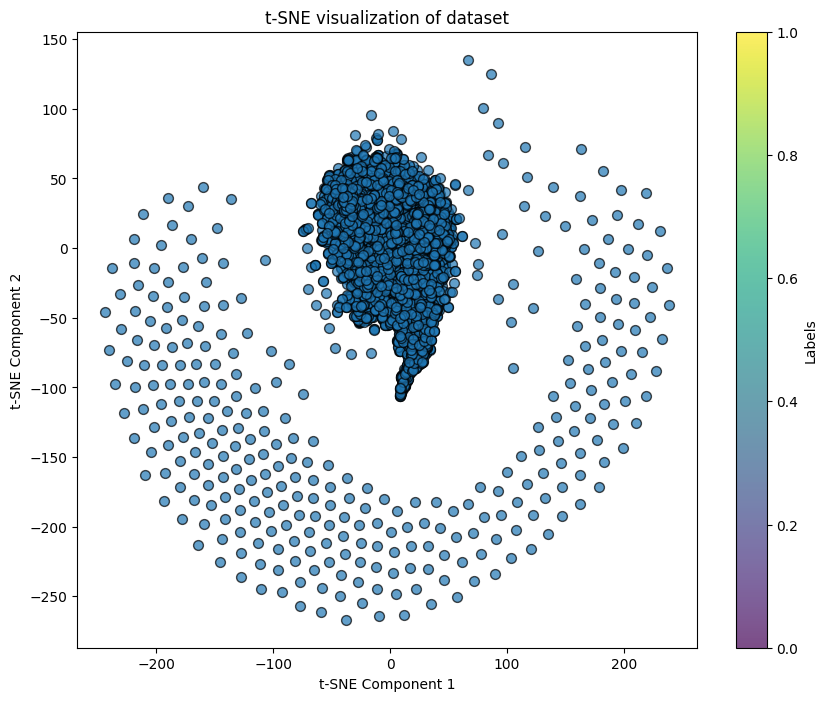

In [264]:
from sklearn.manifold import TSNE
# Create a t-SNE instance and fit_transform the data
tsne = TSNE(n_components=2, random_state=42, perplexity=5, n_iter=5000)
# X_tsne = tsne.fit_transform(df_simil_in.drop(columns=['Provider', 'Is_admit', 'ClmAdmitDiagnosisCode', 'DiagnosisGroupCode',
#        'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
#        'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
#        'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9',
#        'ClmDiagnosisCode_10', 'ClmProcedureCode_1', 'ClmProcedureCode_2',
#        'ClmProcedureCode_3']))

X_tsne = tsne.fit_transform(df_group_data_diag_simil.drop(columns=['Provider']))
print(tsne.kl_divergence_)

# Plotting the t-SNE result
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1],cmap='viridis', alpha=0.7, edgecolors='k', s=50)

# Add legend and title
plt.title('t-SNE visualization of dataset')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(scatter, label='Labels')

plt.show()

/Users/Geethika/Documents/GitHub/Medicare Claims/.venv/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


1.4240446090698242


/var/folders/nd/f34czdrj02175j4j_k03vfyw0000gp/T/ipykernel_20916/1994684077.py:16: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1],cmap='viridis', alpha=0.7, edgecolors='k', s=50)


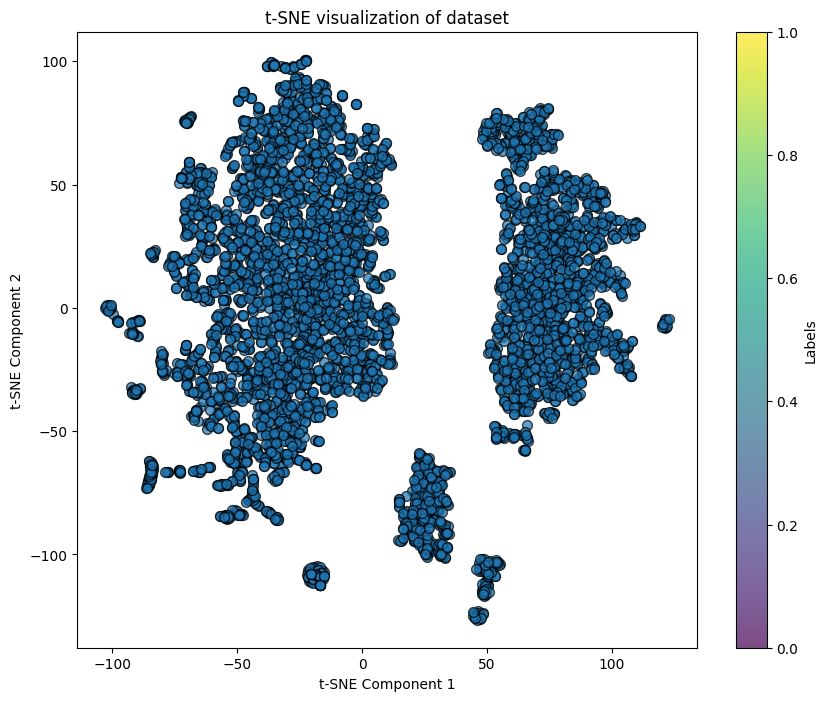

In [284]:
from sklearn.manifold import TSNE
# Create a t-SNE instance and fit_transform the data
tsne = TSNE(n_components=2, random_state=42, perplexity=20, n_iter=5000)
# X_tsne = tsne.fit_transform(df_simil_in.drop(columns=['Provider', 'Is_admit', 'ClmAdmitDiagnosisCode', 'DiagnosisGroupCode',
#        'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
#        'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
#        'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9',
#        'ClmDiagnosisCode_10', 'ClmProcedureCode_1', 'ClmProcedureCode_2',
#        'ClmProcedureCode_3']))

X_tsne = tsne.fit_transform(df_simil_agg_combined.drop(columns=['Provider']))
print(tsne.kl_divergence_)

# Plotting the t-SNE result
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1],cmap='viridis', alpha=0.7, edgecolors='k', s=50)

# Add legend and title
plt.title('t-SNE visualization of dataset')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(scatter, label='Labels')

plt.show()

/Users/Geethika/Documents/GitHub/Medicare Claims/.venv/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


3.8672549724578857


/var/folders/nd/f34czdrj02175j4j_k03vfyw0000gp/T/ipykernel_20916/3100158832.py:16: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1],cmap='viridis', alpha=0.7, edgecolors='k', s=50)


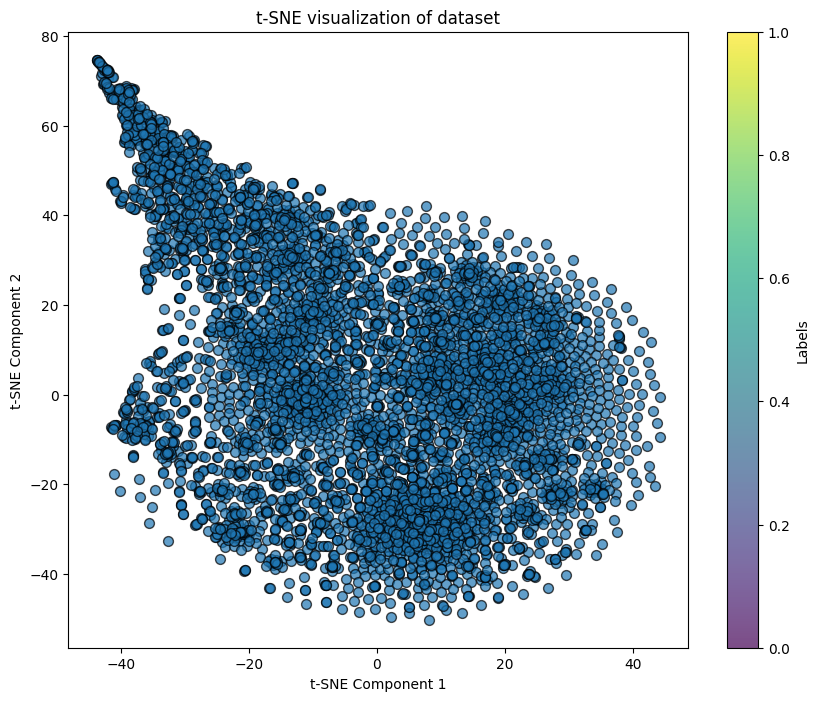

In [289]:
from sklearn.manifold import TSNE
# Create a t-SNE instance and fit_transform the data
tsne = TSNE(n_components=2, random_state=42, perplexity=10, n_iter=5000)
# X_tsne = tsne.fit_transform(df_simil_in.drop(columns=['Provider', 'Is_admit', 'ClmAdmitDiagnosisCode', 'DiagnosisGroupCode',
#        'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
#        'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
#        'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9',
#        'ClmDiagnosisCode_10', 'ClmProcedureCode_1', 'ClmProcedureCode_2',
#        'ClmProcedureCode_3']))

X_tsne = tsne.fit_transform(data_combined.drop(columns=['Provider']))
print(tsne.kl_divergence_)

# Plotting the t-SNE result
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1],cmap='viridis', alpha=0.7, edgecolors='k', s=50)

# Add legend and title
plt.title('t-SNE visualization of dataset')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(scatter, label='Labels')

plt.show()

In [303]:
data_combined

,ClmAdmitDiagnosisCode_0030,ClmAdmitDiagnosisCode_0059,ClmAdmitDiagnosisCode_00845,ClmAdmitDiagnosisCode_0085,ClmAdmitDiagnosisCode_00863,ClmAdmitDiagnosisCode_0088,ClmAdmitDiagnosisCode_0090,ClmAdmitDiagnosisCode_0091,ClmAdmitDiagnosisCode_0092,ClmAdmitDiagnosisCode_0093,...,ClmDiagnosisCode_4_embeddings_ClmDiagnosisCode_5_embeddings_similarity_float_Not Admitted,ClmDiagnosisCode_4_embeddings_ClmDiagnosisCode_5_embeddings_similarity_float_Admitted,ClmDiagnosisCode_5_embeddings_ClmDiagnosisCode_6_embeddings_similarity_float_Not Admitted,ClmDiagnosisCode_5_embeddings_ClmDiagnosisCode_6_embeddings_similarity_float_Admitted,ClmDiagnosisCode_6_embeddings_ClmDiagnosisCode_7_embeddings_similarity_float_Not Admitted,ClmDiagnosisCode_6_embeddings_ClmDiagnosisCode_7_embeddings_similarity_float_Admitted,ClmDiagnosisCode_7_embeddings_ClmDiagnosisCode_8_embeddings_similarity_float_Not Admitted,ClmDiagnosisCode_7_embeddings_ClmDiagnosisCode_8_embeddings_similarity_float_Admitted,ClmDiagnosisCode_8_embeddings_ClmDiagnosisCode_9_embeddings_similarity_float_Not Admitted,ClmDiagnosisCode_8_embeddings_ClmDiagnosisCode_9_embeddings_similarity_float_Admitted
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.134460,0.806577,0.094027,0.760091,0.060389,0.693289,0.044047,0.644046,0.033351,0.582871
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.129560,0.877427,0.084777,0.878674,0.051924,0.826390,0.035935,0.787220,0.029173,0.769657
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.123058,0.000000,0.079984,0.000000,0.051180,0.000000,0.039084,0.000000,0.029217,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.172763,0.893758,0.134924,0.893234,0.085666,0.871830,0.060144,0.657347,0.049223,0.671336
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.119727,0.000000,0.083185,0.000000,0.051027,0.000000,0.024833,0.000000,0.014439,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5405,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.893813,0.000000,0.918408,0.000000,0.909886,0.000000,0.882759,0.000000,0.000000,0.000000
5406,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.917193,0.000000,0.919335,0.000000,0.839986,0.000000,0.870648,0.000000,0.824793
5407,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.088409,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5408,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [53]:
from sklearn.preprocessing import RobustScaler
scaler=RobustScaler()
scaled_data_level1=scaler.fit_transform(data.drop(columns=['Provider']))

In [56]:
scaled_data_level1 = pd.DataFrame(scaled_data_level1, columns=data.drop(columns=['Provider']).columns)

In [57]:
scaled_data_level1

Value,79678,71656,64881,36401,2948,31400,42490,11590,72089,4271,...,E9888,E8710,3203,94225,E8259,90241,0828,E8262,E9192,86131
0,4.448246,49.470680,8.860778,4.593130,56.713932,48.705293,25.899330,30.555489,20.146631,43.616282,...,4.174175,0.000000,10.529650,0.916312,0.907648,0.82918,7.153037,1.760201,0.000000,0.933080
1,3.570520,31.462008,4.427285,3.663936,25.031370,19.977565,18.285833,8.840333,5.454927,22.521430,...,0.893548,0.866638,0.886225,0.000000,0.000000,0.00000,2.626134,0.000000,0.870483,0.000000
2,0.000000,42.468048,5.362335,0.000000,26.005014,43.161831,19.806592,9.575178,12.904735,31.939645,...,3.393852,0.904733,6.148156,0.000000,0.000000,0.00000,2.670272,0.927139,0.000000,0.896457
3,0.000000,4.946434,0.900019,0.000000,0.960301,2.933540,2.007777,2.654306,0.000000,3.053469,...,0.000000,0.000000,0.886225,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
4,0.000000,4.998982,0.000000,0.000000,0.000000,8.436059,3.041670,2.654615,0.000000,4.658437,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5405,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
5406,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
5407,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
5408,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000


In [59]:
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler



# Fit Isolation Forest
model = IsolationForest(contamination=0.1,n_estimators=10000,max_features=10)  # Adjust contamination rate as needed
model.fit(scaled_data_level1)

anomaly_scores = model.decision_function(scaled_data_level1)
# Predict anomalies
anomalies = model.predict(scaled_data_level1)

# -1 for anomaly, 1 for normal
anomaly_indices = np.where(anomalies == -1)[0]
anomalous_data = scaled_data_level1.iloc[anomaly_indices]
anomalous_data_actual = scaled_data_level1.iloc[anomaly_indices]
scaled_data_level1['Anomaly_ind']=anomalies
data['Anomaly_ind']=anomalies
data['Anomaly_score']=anomaly_scores
scaled_data_level1['Anomaly_score']=anomaly_scores

In [98]:
X=scaled_data_level1.drop(columns='Anomaly_score')
y=scaled_data_level1['Anomaly_score']

In [99]:
scaled_data_level1

Value,79678,71656,64881,36401,2948,31400,42490,11590,72089,4271,...,3203,94225,E8259,90241,0828,E8262,E9192,86131,Anomaly_ind,Anomaly_score
0,4.448246,49.470680,8.860778,4.593130,56.713932,48.705293,25.899330,30.555489,20.146631,43.616282,...,10.529650,0.916312,0.907648,0.82918,7.153037,1.760201,0.000000,0.933080,1,-0.262963
1,3.570520,31.462008,4.427285,3.663936,25.031370,19.977565,18.285833,8.840333,5.454927,22.521430,...,0.886225,0.000000,0.000000,0.00000,2.626134,0.000000,0.870483,0.000000,0,-0.139973
2,0.000000,42.468048,5.362335,0.000000,26.005014,43.161831,19.806592,9.575178,12.904735,31.939645,...,6.148156,0.000000,0.000000,0.00000,2.670272,0.927139,0.000000,0.896457,1,-0.252813
3,0.000000,4.946434,0.900019,0.000000,0.960301,2.933540,2.007777,2.654306,0.000000,3.053469,...,0.886225,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0,0.059973
4,0.000000,4.998982,0.000000,0.000000,0.000000,8.436059,3.041670,2.654615,0.000000,4.658437,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0,-0.007429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5405,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0,0.226169
5406,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0,0.226169
5407,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0,0.226169
5408,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0,0.226169


/Users/Geethika/Documents/GitHub/Medicare Claims/.venv/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


0.3710101246833801


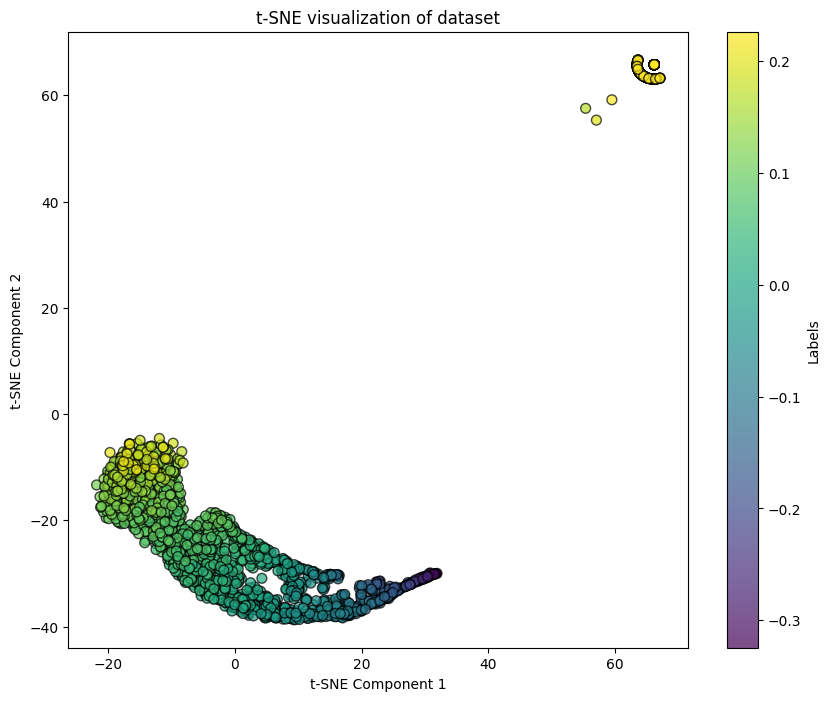

In [100]:
from sklearn.manifold import TSNE
# Create a t-SNE instance and fit_transform the data
tsne = TSNE(n_components=2, random_state=42, perplexity=50, n_iter=5000)
# X_tsne = tsne.fit_transform(df_simil_in.drop(columns=['Provider', 'Is_admit', 'ClmAdmitDiagnosisCode', 'DiagnosisGroupCode',
#        'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
#        'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
#        'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9',
#        'ClmDiagnosisCode_10', 'ClmProcedureCode_1', 'ClmProcedureCode_2',
#        'ClmProcedureCode_3']))

X_tsne = tsne.fit_transform(X)
print(tsne.kl_divergence_)

# Plotting the t-SNE result
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1],c=y,cmap='viridis', alpha=0.7, edgecolors='k', s=50)

# Add legend and title
plt.title('t-SNE visualization of dataset')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(scatter, label='Labels')

plt.show()

In [87]:
data['Anomaly_ind'] = data['Anomaly_score'].apply(lambda x: 1 if x <= -0.2 else 0)
scaled_data_level1['Anomaly_ind'] = scaled_data_level1['Anomaly_score'].apply(lambda x: 1 if x <=-0.2 else 0)

In [88]:
dataset_anom=data[data.Anomaly_ind==1]
dataset_normal=data[data.Anomaly_ind==0]
dataset_anom_scale=scaled_data_level1[scaled_data_level1.Anomaly_ind==1]
dataset_normal_scale=scaled_data_level1[scaled_data_level1.Anomaly_ind==0]

In [89]:
dataset_normal

Value,79678,71656,64881,36401,2948,31400,42490,11590,72089,4271,...,94225,E8259,90241,0828,E8262,E9192,86131,Provider,Anomaly_ind,Anomaly_score
1,3.57052,28.451379,4.427285,3.663936,22.438268,35.676416,32.486534,8.840333,5.454927,59.669544,...,0.000000,0.000000,0.000000,2.626134,0.000000,0.870483,0.000000,PRV55158,0,-0.139973
3,0.00000,4.473106,0.900019,0.000000,0.860820,5.238786,3.567008,2.654306,0.000000,8.090033,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,PRV54890,0,0.059973
4,0.00000,4.520625,0.000000,0.000000,0.000000,15.065316,5.403818,2.654615,0.000000,12.342326,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,PRV52145,0,-0.007429
5,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,PRV54683,0,0.226169
6,0.00000,28.581220,2.704931,0.000000,20.959427,44.372900,48.741060,10.556219,5.679239,54.942022,...,0.916563,0.856924,1.751426,4.487467,0.876639,1.738588,0.943428,PRV54986,0,-0.155954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5405,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,PRV54294,0,0.226169
5406,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,PRV51053,0,0.226169
5407,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,PRV55405,0,0.226169
5408,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,PRV57061,0,0.226169


In [90]:
import shap
explainer=shap.TreeExplainer(model)
shap_values=explainer(dataset_anom.drop(columns='Provider'))
#shap_values_norm=explainer(dataset_normal)

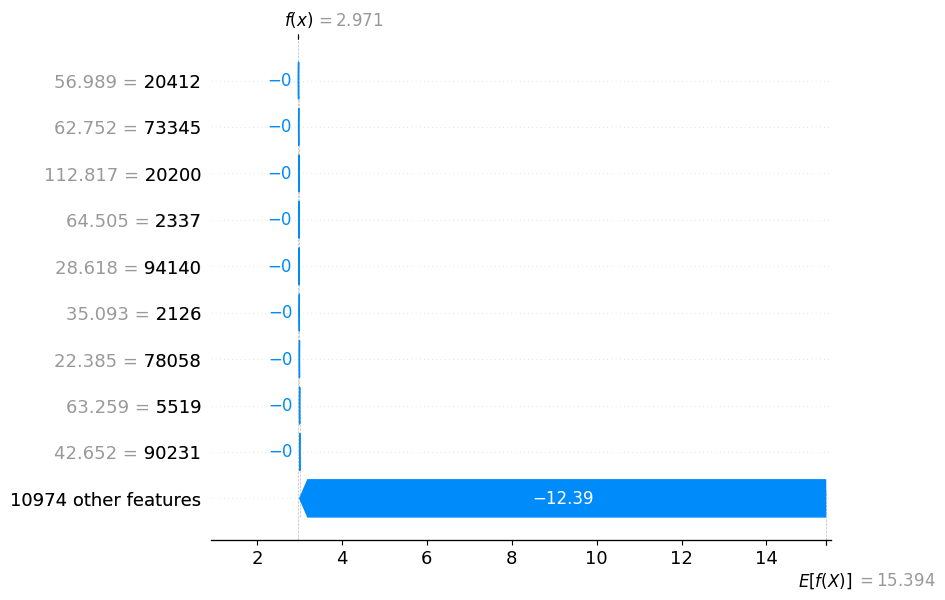

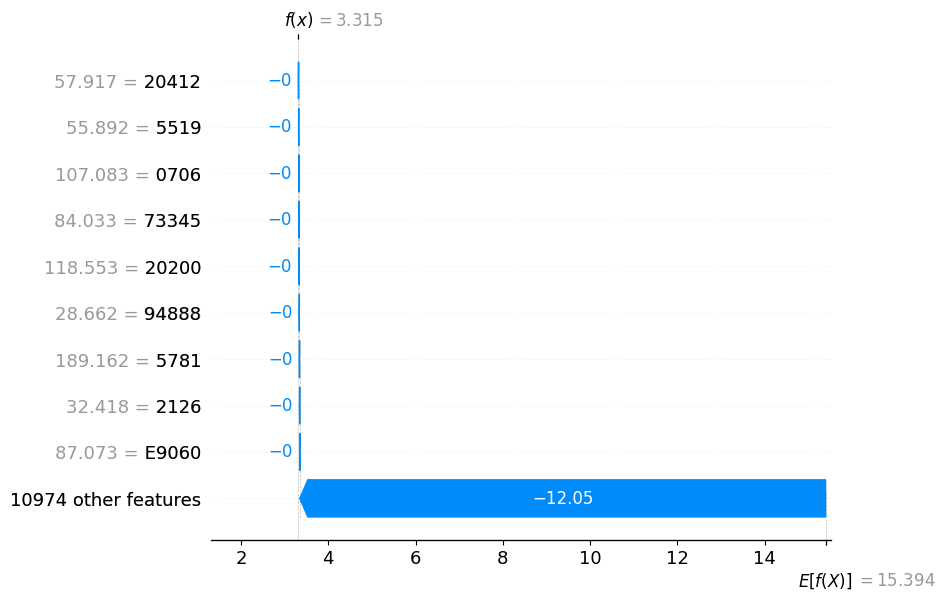

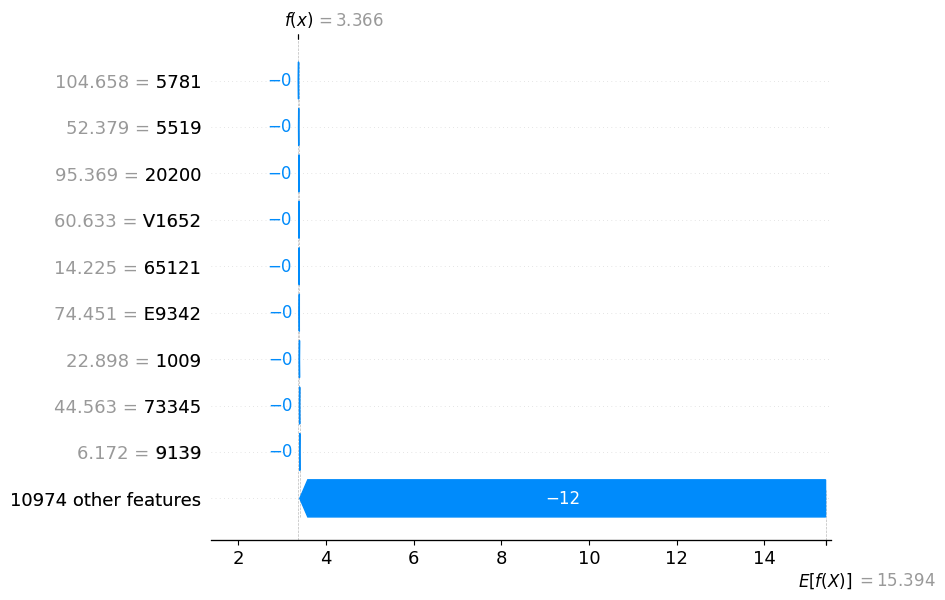

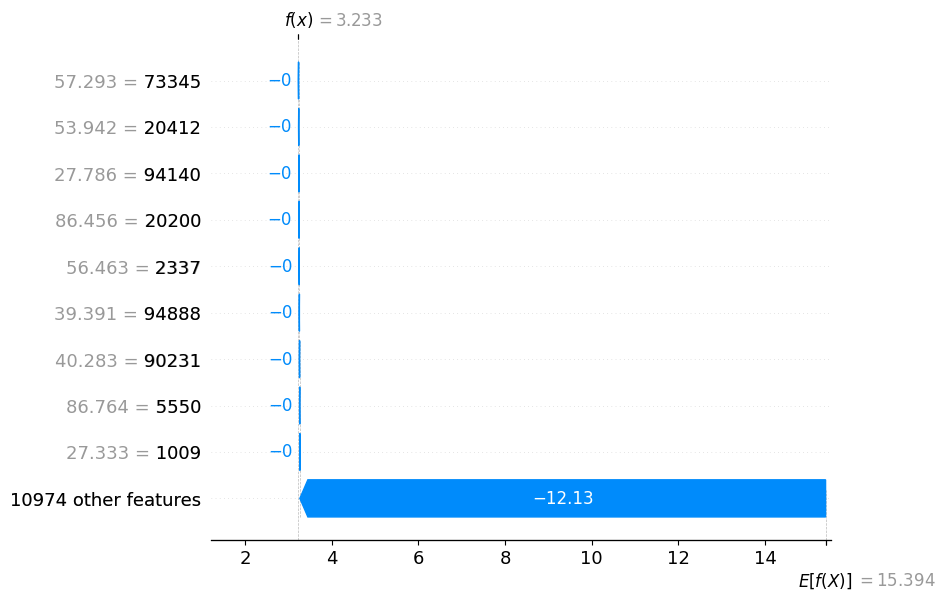

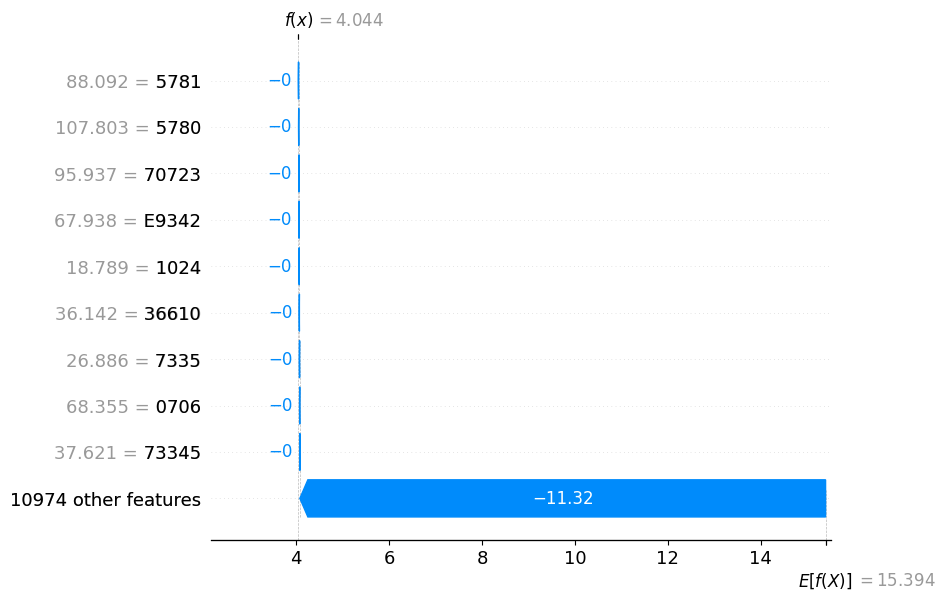

In [101]:
for i in range(45,50):
    shap.plots.waterfall(shap_values[i])

In [203]:
X_tsne

array([[ -41.23045  ,   54.14555  ],
       [ -33.81043  , -132.0513   ],
       [ -13.1324625,   49.016422 ],
       ...,
       [-126.87326  ,   72.953354 ],
       [ -58.782623 , -514.1651   ],
       [-526.05286  ,   44.552402 ]], dtype=float32)

In [207]:
df_simil_in[df_simil_in.Provider=='PRV57710']

,Provider,Is_admit,ClmAdmitDiagnosisCode,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,...,Diagnosis_Combined_mean_DiagnosisGroupCode_embeddings_similarity_float,DiagnosisGroupCode_embeddings_ClmAdmitDiagnosisCode_embeddings_similarity_float,ClmDiagnosisCode_1_embeddings_ClmDiagnosisCode_2_embeddings_similarity_float,ClmDiagnosisCode_2_embeddings_ClmDiagnosisCode_3_embeddings_similarity_float,ClmDiagnosisCode_3_embeddings_ClmDiagnosisCode_4_embeddings_similarity_float,ClmDiagnosisCode_4_embeddings_ClmDiagnosisCode_5_embeddings_similarity_float,ClmDiagnosisCode_5_embeddings_ClmDiagnosisCode_6_embeddings_similarity_float,ClmDiagnosisCode_6_embeddings_ClmDiagnosisCode_7_embeddings_similarity_float,ClmDiagnosisCode_7_embeddings_ClmDiagnosisCode_8_embeddings_similarity_float,ClmDiagnosisCode_8_embeddings_ClmDiagnosisCode_9_embeddings_similarity_float
649,PRV57710,0,0,0,V5391,2720,5889,4011,3550,0,...,0.0,0.0,0.905445,0.925472,0.920868,0.910986,0.0,0.0,0.0,0.0


In [213]:
df_simil_in

,Provider,Is_admit,ClmAdmitDiagnosisCode,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,...,Diagnosis_Combined_mean_DiagnosisGroupCode_embeddings_similarity_float,DiagnosisGroupCode_embeddings_ClmAdmitDiagnosisCode_embeddings_similarity_float,ClmDiagnosisCode_1_embeddings_ClmDiagnosisCode_2_embeddings_similarity_float,ClmDiagnosisCode_2_embeddings_ClmDiagnosisCode_3_embeddings_similarity_float,ClmDiagnosisCode_3_embeddings_ClmDiagnosisCode_4_embeddings_similarity_float,ClmDiagnosisCode_4_embeddings_ClmDiagnosisCode_5_embeddings_similarity_float,ClmDiagnosisCode_5_embeddings_ClmDiagnosisCode_6_embeddings_similarity_float,ClmDiagnosisCode_6_embeddings_ClmDiagnosisCode_7_embeddings_similarity_float,ClmDiagnosisCode_7_embeddings_ClmDiagnosisCode_8_embeddings_similarity_float,ClmDiagnosisCode_8_embeddings_ClmDiagnosisCode_9_embeddings_similarity_float
0,PRV57172,0,0,0,79678,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,PRV57172,0,0,0,71656,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,PRV55158,0,64880,0,64881,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,PRV54966,0,36401,0,36401,V4569,0,0,0,0,...,0.000000,0.000000,0.902907,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,PRV54890,0,78009,0,2948,4019,2989,78054,2875,78830,...,0.000000,0.000000,0.897208,0.952786,0.901493,0.948612,0.944085,0.893478,0.875444,0.903405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,PRV56689,0,0,0,7226,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
996,PRV57049,1,2989,887,29570,3310,4019,V4501,33829,53081,...,0.302598,0.928243,0.843559,0.900558,0.906890,0.949814,0.859016,0.913059,0.884059,0.867710
997,PRV56628,0,4241,0,42491,79439,0,0,0,0,...,0.000000,0.000000,0.892259,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
998,PRV52402,0,V571,0,43884,72887,0,0,0,0,...,0.000000,0.000000,0.865585,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [209]:
total_data.iloc[516]

Provider                        PRV57710
ClmAdmitDiagnosisCode  0               1
                       0389            0
                       07054           0
                       1101            0
                                  ...   
ClmDiagnosisCode_1     V8271           0
                       V854            0
                       V860            0
                       V8712           0
                       V8749           0
Name: 516, Length: 897, dtype: object